<a href="https://colab.research.google.com/github/iitmcvg/InterIIT_2021/blob/model_eval/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import os
import PIL
from PIL import Image
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
IMG_SIZE=224
NUM_CLASSES=43

In [5]:
img_augmentation = Sequential(
    [
          preprocessing.RandomRotation(factor=0.2),
        preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        #preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)



preprocess_input = tf.keras.applications.efficientnet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [6]:
base_model = EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')

16711680/16705208 [==============================] - 0s 0us/step


In [7]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                55083     
Total params: 4,104,654
Trainable params: 55,083
Non-trainable params: 4,049,571
______________________________________________

In [9]:
base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [10]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                55083     
Total params: 4,104,654
Trainable params: 3,342,787
Non-trainable params: 761,867
_____________________________________________

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
model.load_weights("/content/drive/MyDrive/weights_resnet.hdf5")

In [13]:
!unzip /content/drive/MyDrive/GTSRB_Online-Test-Images-Sorted.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Online-Test-sort/00015/00003_00008.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00009.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00010.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00011.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00012.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00013.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00014.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00015.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00016.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00017.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00018.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00019.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00020.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00021.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_00022.ppm  
  inflating: GTSRB/Online-Test-sort/00015/00003_0

In [14]:
for subdir, dirs, files in tqdm(os.walk("GTSRB/Online-Test-sort/")):
    for file in files:
      if(file[-4:] == ".ppm"):
        f=os.path.join(subdir, file)
        im = Image.open(f)
        x=file[:-4]+".png"
        os.remove(f)
        f=os.path.join(subdir, x)
        im.save(f)
      elif file[-4:] == ".csv":
        os.remove(f)

In [15]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "GTSRB/Online-Test-sort/",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE))

Found 12526 files belonging to 44 classes.


In [16]:
loss0, accuracy0 = model.evaluate(test_dataset)

392/392 [==============================] - 71s 94ms/step - loss: 0.0198 - accuracy: 0.9939


In [22]:
y1 = np.array([])
y2 = np.array([])

for x, y in tqdm(test_dataset):
  y_true=np.argmax(model.predict(x),axis=1)
  y1=np.append(y1,y_true)
  y2=np.append(y2,y.numpy())

In [23]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(y1, y2)*100)

Test Data accuracy:  99.465112565863


In [24]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y1, y2)

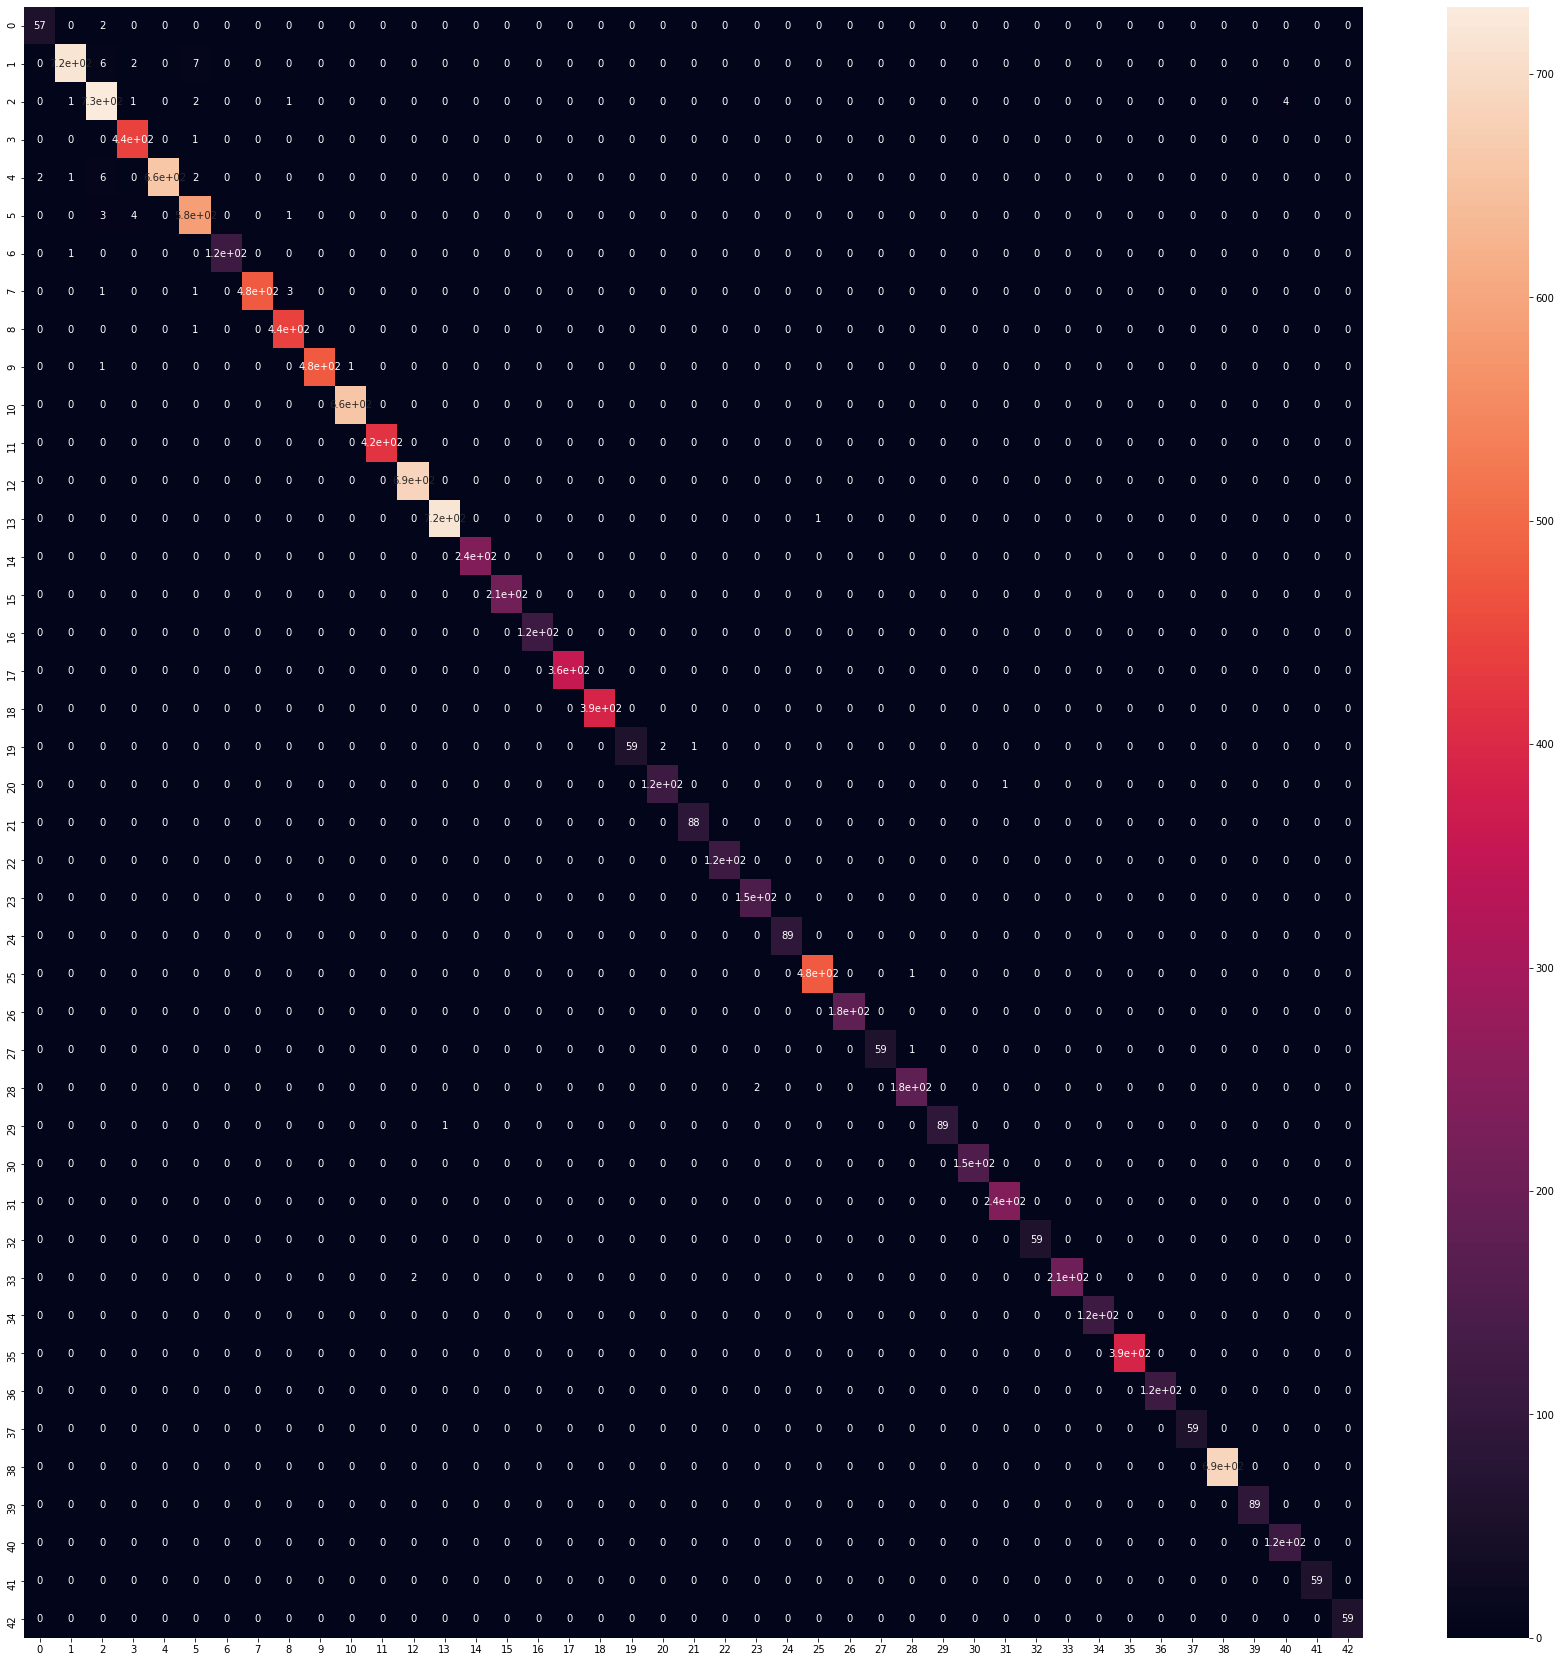

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cf)
plt.figure(figsize = (30,30))
sns.heatmap(df_cm, annot=True)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y1, y2))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        59
         1.0       1.00      0.98      0.99       731
         2.0       0.97      0.99      0.98       739
         3.0       0.98      1.00      0.99       443
         4.0       1.00      0.98      0.99       670
         5.0       0.98      0.99      0.98       593
         6.0       1.00      0.99      1.00       120
         7.0       1.00      0.99      0.99       484
         8.0       0.99      1.00      0.99       445
         9.0       1.00      1.00      1.00       481
        10.0       1.00      1.00      1.00       658
        11.0       1.00      1.00      1.00       419
        12.0       1.00      1.00      1.00       687
        13.0       1.00      1.00      1.00       719
        14.0       1.00      1.00      1.00       239
        15.0       1.00      1.00      1.00       209
        16.0       1.00      1.00      1.00       119
        17.0       1.00    